In [1]:
#Symbolic comptation
import sympy as sy
from sympy.functions.elementary.exponential import exp as sy_exp

#Library to deal with datetime objects sh*t
import datetime as dt

#Numerical computation
import numpy as np
from numpy.random import normal as N

#Data operation
import pandas as pd

#Statistical library
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#plot library
import matplotlib.pyplot as plt

#
import requests

In [2]:
def getDailyAdj(symbol:str, key:str) -> pd.DataFrame:
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+symbol+'&outputsize=full&apikey='+key
    r = requests.get(url)
    data = r.json()

    data = pd.DataFrame(data['Time Series (Daily)']).T
    data.rename(columns={'1. open':'Open', '2. high':'High', '3. low':'Low', 
                       '4. close':'Close', '5. adjusted close':'Adj Close', 
                       '6. volume':'Volume', '7. dividend amount': 'Dividends', 
                       '8. split coefficient':'Split coefficient'}, inplace=True)
    data.index = pd.to_datetime(data.index)
    data.sort_index(inplace=True)
    for col in data.columns:
        data[col] = pd.to_numeric(data[col])
    return data

In [3]:
key = '' #Insira aqui a API do Alpha vantage, caso não tenha é gratuita (https://www.alphavantage.co/)
ticker = 'BOVA11.SAO'
start_date = '2020-06-01'
S = getDailyAdj(ticker, key)

In [4]:
global n
x = S.loc[(S.index>=pd.to_datetime(start_date))]
n = len(x)

# Parameter Estimation in Mean Reversion Processes with Deterministic Long-Term Trend

$$dX_t = \alpha(\mu(t) - X_t)dt + \sigma X_t^\gamma dB_t$$

#### Freddy H. Marín Sánchez and Verónica M. Gallego

by Euler-Maruyama method:
$$Y_t = \frac{X_t - X_{t-1} - \left[\alpha(m_{t-1} - X_{t-1}) + \dot{m}_{t-1}\right]}{X^{\gamma}_{t-1}}\Delta$$
where $Y_t \sim N(0, \sigma^2 \Delta)$, which $\Delta = \frac{1}{n}$

In [5]:
Δ = 1
x = x['Adj Close']
x0 = x[0]
x = x/x0

## Hodrick-Prescott Filter
$$\min_{\{g_t\}_{t=1}^T} \big\{\sum_{t=1}^T c_t^2 + \lambda\sum_{t=1}^T[(g_t - g_{t-1})-(g_{t-1}-g_{t-2})]^2\big\}$$
where $c_t = x_t - g_t$

In [6]:
def MA(x,n_rolling):
    m = x.rolling(n_rolling).mean().iloc[n_rolling-1:]
    x = x.iloc[n_rolling-1:]
    return x,m

cycle, m = sm.tsa.filters.hpfilter(x, 12000)
#x,m = MA(x,120)
m = m.rename('Adj Close')
n = len(x)

$$\dot{m}_i = \frac{2m_{i+1} - 3m_i + m_{i-1}}{\Delta}$$
for i = 1,2,...T-1. if i=0 or i=T we have:
$$\dot{m}_0 = \frac{m_1 - m_0}{\Delta}$$
$$\dot{m}_T = \frac{m_T - m_{T-1}}{\Delta}$$

In [7]:
m_ = np.zeros(n)
T = n-1
m_[0] = (m[1] - m[0])/Δ
m_[n-1] = (m[T] - m[T-1])/Δ
for i in range(1, T):
    m_[i] = (2*m[i+1] - 3*m[i] + m[i-1])/Δ

Reversion Rate:
$$\hat{\alpha} = \frac{\sum_{i=1}^T \left((X_i - X_{i-1} - \dot{m}_{i-1}\Delta)(m_{i-1} - X_{i-1})/X_{i-1}^{2\gamma}\right)}{\sum_{i=1}^T\left[(m_{i-1} - X_{i-1})/X_{i-1}^\gamma\right]^2\Delta}$$

In [8]:
γ = 1
α = sum(((x[i] - x[i-1] - m_[i-1]*Δ)*(m[i-1] - x[i-1]))/(x[i-1]**(2*γ)) for i in range(1,n))/(Δ*sum(((m[i-1] - x[i-1])/(x[i-1]**(γ)))**2 for i in range(1, n)))

Volatility:
$$\hat{\sigma} = \sqrt{\frac{1}{T\Delta}\sum_{i=1}^T \left(\frac{X_i - X_{i-1} -[\hat{\alpha}(m_{i-1} - X_{i-1}) + \dot{m}_{i-1}]\Delta}{X_{i-1}^\gamma}\right)^2}$$

In [9]:
σ = ((1/n*Δ)*sum(((x[i] - x[i-1] - (α*(m[i-1] - x[i-1]) + m_[i-1])*Δ)/(x[i-1]**γ))**2 for i in range(1,n)))**(0.5)

Long mean-trend:
$$\mu(t) = m(t) + \frac{\dot{m}(t)}{\alpha}$$

In [10]:
μ = np.zeros(n)
for t in range(n):
    μ[t] = m[t] + (m_[t]/α)

Euler-Maruyama numerical method:
$$X(\tau_t) = X(\tau_{t-1}) + \alpha(\mu_{t-1} - X(\tau_{t-1})\Delta + X^\gamma(\tau_{t-1}) \epsilon_{\tau_t}$$

where $\epsilon_{\tau_t} \sim N(0, \sigma^2 \Delta )$

In [11]:
#Monte carlo do processo
X = np.zeros(len(μ))
X[0] = x[0]
for t in range(1, len(X)):
    ϵ = N(0, σ*Δ)
    X[t] =  X[t-1] + α*(μ[t-1] - X[t-1])*Δ + (X[t-1]**γ)*ϵ

$$Var(X_T) = \mathbb{E}[(X_T - \mathbb{E}[X_T])^2] = \mathbb{E}[(\sigma \int_0^T e^{-\alpha(T-t)} dt)^2] \\ = \quad \sigma^2 \int_0^T e^{-2\alpha (T-t)}dt =  \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha T})$$

# Notes

Now we'll plot our data and estimated parameters (such as our deterministic long term trend function)

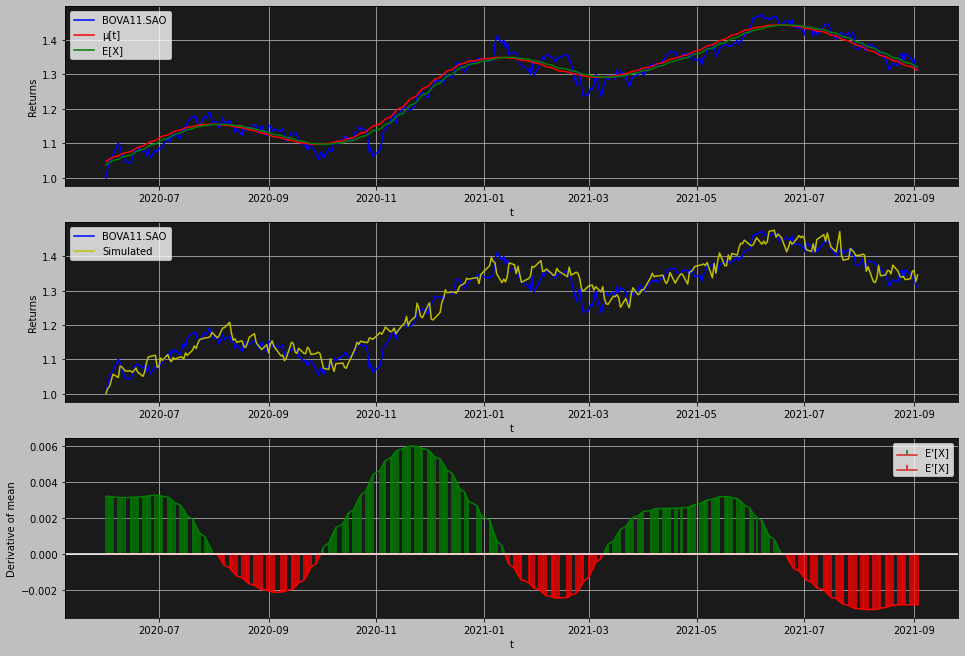

In [12]:
X = pd.DataFrame(X, index=x.index, columns=['Adj Close'])
μ = pd.DataFrame(μ, index=x.index, columns=['Adj Close'])
m = pd.DataFrame(m, index=x.index, columns=['Adj Close'])

fig, ax= plt.subplots(3, figsize=(16,11.25), facecolor=(0.75, 0.75, 0.75))

#ax1 plots
ax[0].plot(x, label=ticker, color='b', linewidth=1.5)
ax[0].plot(μ, label='μ[t]', color='r', linewidth=1.5)
ax[0].plot(m, label='E[X]', color='g', linewidth=1.5)
ax[0].set_ylabel('Returns')


#ax2 Plots
ax[1].plot(x, label=ticker, color='b', linewidth=1.5)
ax[1].plot(X['Adj Close'], label='Simulated', color='y', linewidth=1.5)
ax[1].set_ylabel('Returns')
#ax3 plots
m_positive = []
m_negative = []
for Ex in m_:
    if Ex>=0:
        m_positive.append(Ex)
        m_negative.append(float('nan'))
    else:
        m_negative.append(Ex)
        m_positive.append(float('nan'))
        

m_positive = pd.DataFrame(m_positive, columns=['positive_derivative'], index=x.index[-len(m_positive):])
m_negative = pd.DataFrame(m_negative, columns=['negative_derivative'], index=x.index[-len(m_negative):])

ax[2].stem(m_positive.index, m_positive['positive_derivative'], markerfmt='green', use_line_collection=True, label='E\'[X]', linefmt='green')
ax[2].stem(m_negative.index, m_negative['negative_derivative'], markerfmt='red', use_line_collection=True, label='E\'[X]', linefmt='red')
ax[2].axhline(y=0, color='w')
ax[2].set_ylabel('Derivative of mean')



for axes in ax:
    axes.set_facecolor((0.1, 0.1, 0.1))
    axes.grid(True)
    axes.set_xlabel('t')
    axes.legend()

#fig.autofmt_xdate()
plt.show()

## Phase 2: Re-estimation

We want to estimate the vector parameter $\Theta$ which minimizes an error function defined by:
$$Error(\Theta) = \sum_{t=1}^T [f(\Theta, t) - \hat{\mu}(t)]^2$$

$$Error(\Gamma) = \sum_{t=1}^T [g(\Gamma, t) - \hat{\mu}(t)]^2$$

Choose a function type:
* $f(\Theta, t) =  a_0 + a_1t + ... +  a_{n-1}t^{n-1} + a_nt^n, \Theta = [a_n, a_{n-1}, ..., a_1, a_0]$
* $g(\Theta, t) = a + b\sin{((2\pi/P)t)}, \Gamma = [a, b]$

In [13]:
t = sy.Symbol('t')

In [14]:
P = 60
Γ = (sy.Symbol('a'), sy.Symbol('b'))
g = Γ[0] + Γ[1]*sy.sin((2*sy.pi/P)*t)
g = sy.lambdify(t, g)
Erro_Γ = sum((g(t) - μ['Adj Close'][t])**2 for t in range(n))
del_g = [sy.diff(Erro_Γ, γ) for γ in Γ]
s_g = sy.solve(del_g)
g = s_g[Γ[0]] + s_g[Γ[1]]*sy.sin((2*sy.pi/P)*t)

In [15]:
n_grau = 3 #Polynomial degree to be re estimated
a = sy.symbols('a0:'+str(n_grau+1))
Θ = a
f = sum(a[i]*(t**i) for i in range(n_grau+1))
f = sy.lambdify(t,f)
Error_Θ = sum((f(t) - μ['Adj Close'][t])**2 for t in range(n))
del_f = [sy.diff(Error_Θ, θ) for θ in Θ]
s_f = sy.solve(del_f)
f = sum(s_f[a[i]]*(t**i) for i in range(0,n_grau+1))

In [16]:
μ_re_est_f = sy.lambdify(t, f)
μ_re_est_g = sy.lambdify(t, g)

$$\hat{\hat{\alpha}} = \frac{\sum_{i=1}^T \left((X_i - X_{i-1})(\hat{\hat{\mu}}_{i-1} - X_{i-1})\Delta/X_{i-1}^{2\gamma}\right)}{\sum_{i=1}^T\left[(\hat{\hat{\mu}}_{i-1} - X_{i-1})/X_{i-1}^\gamma)\right]^2\Delta}$$

In [17]:
α_re_est_f = sum((x[i] - x[i-1])*(μ_re_est_f(i-1) - x[i-1])*(Δ/(x[i-1]**(2*γ))) for i in range(n))/(sum((((μ_re_est_f(i-1) - x[i-1])/(x[i-1]**γ))**2)*Δ for i in range(n)))
α_re_est_g = sum((x[i] - x[i-1])*(μ_re_est_g(i-1) - x[i-1])*(Δ/(x[i-1]**(2*γ))) for i in range(n))/(sum((((μ_re_est_g(i-1) - x[i-1])/(x[i-1]**γ))**2)*Δ for i in range(n)))

$$\hat{\hat{\sigma}} = \sqrt{\frac{1}{T\Delta} \sum_{i=1}^T \left(\frac{X_i - X_{i-1} - \hat{\hat{\alpha}}(\hat{\hat{\mu}}_{i-1} - X_{i-1})\Delta}{X_{i-1}^\gamma}\right)^2}$$

In [18]:
σ_re_est_f = sy.sqrt((1/n*Δ)*sum((((x[i] - x[i-1]) - α_re_est_f*(μ_re_est_f(i-1) - x[i-1])*Δ)/(x[i-1]**γ))**2 for i in range(n)))
σ_re_est_g = sy.sqrt((1/n*Δ)*sum((((x[i] - x[i-1]) - α_re_est_g*(μ_re_est_g(i-1) - x[i-1])*Δ)/(x[i-1]**γ))**2 for i in range(n)))

$$X_t - X_0 = \alpha \int_0^t(\mu(s) - X_s)ds + \sigma \int_0^t X_s^{\gamma}dB_s$$ <br>
$$\mathop{\mathbb{E}}[X_t] - \mathop{\mathbb{E}}[X_0] = \alpha \int_0^t (\mu(s) - \mathop{\mathbb{E}}[X_s])$$ <br>
$$\dot{m}(t) = \alpha(\mu(t) - m(t))$$ <br>
$$m(t) = a + \left[m_0 - a + \frac{\alpha \beta b}{\alpha^2 + \beta^2} \right]e^{-\alpha t} + \frac{\alpha b}{\alpha^2 + \beta^2}\left[\alpha \sin{\beta t} - \beta \cos{\beta t}\right]$$

In [19]:
t = sy.Symbol('t')
a = s_g[Γ[0]]
b = s_g[Γ[1]]
m0 = m['Adj Close'].iloc[0]
β = 2*sy.pi/P
m_re_estimated_g = a + (m0 - a + ((α_re_est_g*β*b)/(α_re_est_g**2 + β**2)))*sy_exp(-α_re_est_g*t) + ((α_re_est_g*b)/(α_re_est_g**2 + β**2))*(α_re_est_g*sy.sin(β*t) - β*sy.cos(β*t))
m_re_estimated_g_ = sy.diff(m_re_estimated_g, t)
m_re_estimated_g = sy.lambdify(t, m_re_estimated_g)
m_re_estimated_g_ = sy.lambdify(t, m_re_estimated_g_)

In [20]:
m_re_estimated_f = sy.symbols('m', cls=sy.Function)
Equation = sy.Eq(m_re_estimated_f(t).diff(t), α_re_est_f*(f - m_re_estimated_f(t)))
m_re_estimated_f = sy.dsolve(Equation, ics={m_re_estimated_f(0):m['Adj Close'].iloc[0]}).rhs
m_re_estimated_f_ = sy.lambdify(t, m_re_estimated_f.diff(t))
m_re_estimated_f = sy.lambdify(t, m_re_estimated_f)

$$dX_t = dX_{t-1} + \alpha(\mu_{t-1} - dX_{t-1}) + \epsilon X_{t-1}^\gamma $$
<br>where $\epsilon \sim (0, \sigma^2\Delta_t)$ and $\Delta_t = \tau_t - \tau_{t-1}$


In [21]:
σt = sy.sqrt(σ_re_est_f/(2*α_re_est_f)*(1-sy_exp(-2*α_re_est_f*t)))
σt = sy.lambdify(t, σt)

In [22]:
days_forecast = 5

nans = np.array([[float('NaN')] for k in range(1,n)])
forecast_index = [x.index[-1]]
for i in range(1, days_forecast):
    date = forecast_index[-1]
    if date.isoweekday()==5:
        forecast_index.append(forecast_index[-1]+dt.timedelta(days=3))
    else:
        forecast_index.append(forecast_index[-1]+dt.timedelta(days=1))

# Notes

You don't need to understand the code, just understand that we'll plot the data that was estimated and compare with the re-estimated parameters

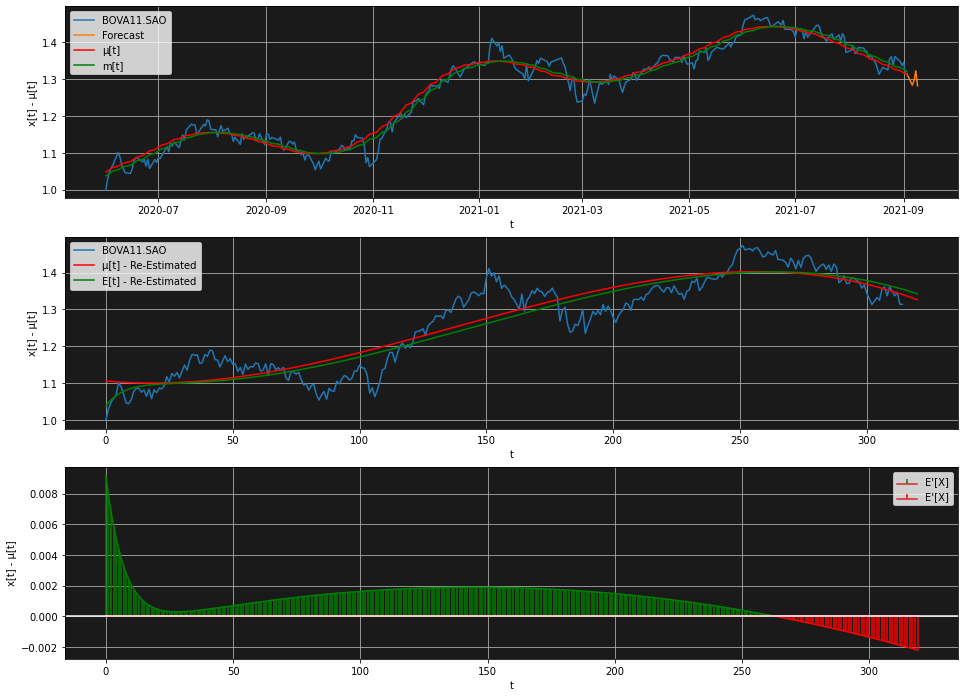

In [25]:
X = np.zeros(days_forecast)
X[0] = x[-1]
for t in range(1, days_forecast):
    ϵ = N(0, σ_re_est_f)
    X[t] =  X[t-1] + σ_re_est_f*(μ_re_est_f(t-1+n) - X[t-1])*Δ + (X[t-1]**γ)*ϵ

#No "Forecast" deveria ser aplicado um monte carlo, mas você ja tem o codigo
#O resto fica por sua conta
X = pd.DataFrame(X, index=pd.to_datetime(forecast_index), columns=['Adj Close'])

fig, ax = plt.subplots(3, figsize=(16, 12))
#ax.fill_between(t1, μ_(t1)+σ, μ_(t1)-σ, facecolor='yellow')


#ax1 plots
ax[0].plot(x, label=ticker)
ax[0].plot(X, label='Forecast')
ax[0].plot(μ, label='μ[t]', color='Red')
ax[0].plot(m, label='m[t]', color='Green')



#ax2 plots
t = np.arange(0, n+days_forecast, (1/n))
ax[1].plot(x.values, label=ticker)
ax[1].plot(t, μ_re_est_f(t), label='μ[t] - Re-Estimated', color='Red')
ax[1].plot(t, m_re_estimated_f(t), label='E[t] - Re-Estimated', color='Green')




#ax3 plots
t = sy.Symbol('t')
k = np.arange(0, n+days_forecast, 1.0)

m_positive = []
m_negative = []
for Ex in m_re_estimated_f_(k):
    if Ex>=0:
        m_positive.append(Ex)
        m_negative.append(float('nan'))
    else:
        m_negative.append(Ex)
        m_positive.append(float('nan'))
ax[2].stem(m_positive, markerfmt='green', use_line_collection=True, label='E\'[X]', linefmt='green')
ax[2].stem(m_negative, markerfmt='red', use_line_collection=True, label='E\'[X]', linefmt='red')
ax[2].axhline(y=0, color='w')

for axes in ax:
    axes.set_facecolor((0.1, 0.1, 0.1))
    axes.grid(True)
    
    axes.set_ylabel('x[t] - μ[t]')
    axes.set_xlabel('t')
    axes.legend()

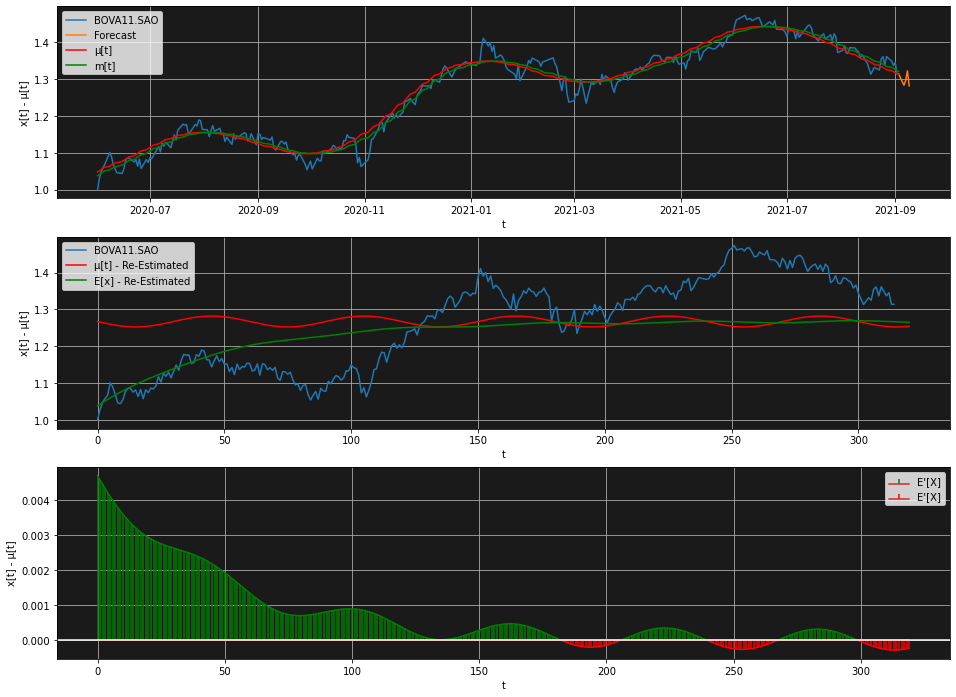

In [26]:
X = pd.DataFrame(X, index=pd.to_datetime(forecast_index), columns=['Adj Close'])
    
fig2, ax = plt.subplots(3, figsize=(16,12))


#ax1 plots
ax[0].plot(x, label=ticker)
ax[0].plot(X, label='Forecast')
ax[0].plot(μ, label='μ[t]', color='Red')
ax[0].plot(m, label='m[t]', color='Green')


#ax2 plots
t = np.arange(0,n+days_forecast, 0.01)
ax[1].plot(x.values, label=ticker)
ax[1].plot(t, μ_re_est_g(t), label='μ[t] - Re-Estimated', color='Red')
ax[1].plot(t, m_re_estimated_g(t), label='E[x] - Re-Estimated', color='Green')




#ax3 plots
k = np.arange(0, n+days_forecast, 1.0)
m_positive = []
m_negative = []
for Ex in m_re_estimated_g_(k):
    if Ex>=0:
        m_positive.append(Ex)
        m_negative.append(float('nan'))
    else:
        m_negative.append(Ex)
        m_positive.append(float('nan'))
ax[2].stem(m_positive, markerfmt='green', use_line_collection=True, label='E\'[X]', linefmt='green')
ax[2].stem(m_negative, markerfmt='red', use_line_collection=True, label='E\'[X]', linefmt='red')
ax[2].axhline(y=0, color='w')

for axes in ax:
    axes.set_facecolor((0.1, 0.1, 0.1))
    axes.grid(True)
    axes.set_ylabel('x[t] - μ[t]')
    axes.set_xlabel('t')
    axes.legend()


plt.show()